In [1]:
import datetime
import re
import os

from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser

In [2]:
import json
from datetime import datetime, timezone, timedelta
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build

In [3]:
def retrive_calendar_events(user, start, end):
    events_list = []
    token_path = "Keys/"+user.split("@")[0]+".token"
    user_creds = Credentials.from_authorized_user_file(token_path)
    calendar_service = build("calendar", "v3", credentials=user_creds)
    events_result = calendar_service.events().list(calendarId='primary', timeMin=start,timeMax=end,singleEvents=True,orderBy='startTime').execute()
    events = events_result.get('items')

    count=0
    for event in events : 
        attendee_list = []
        try:
            for attendee in event["attendees"]: 
                attendee_list.append(attendee['email'])
        except: 
            attendee_list.append("SELF")
        try:
            start_time = event["start"]["dateTime"]
            end_time = event["end"]["dateTime"]
            events_list.append(
                {"StartTime" : start_time, 
                 "EndTime": end_time, 
                 "NumAttendees" :len(set(attendee_list)), 
                 "Attendees" : list(set(attendee_list)),
                 "Summary" : event["summary"]})
        except Exception as E:
            count+=1
    print('No of exceptions are: ',count)
    return events_list

In [4]:
event = retrive_calendar_events("userone.amd@gmail.com", '2023-07-17T00:00:00+05:30', '2026-07-17T23:59:59+05:30')

No of exceptions are:  51


In [5]:
os.environ["LANGSMITH_API_KEY"] = "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"
os.environ["LANGSMITH_TRACING"] = "true"

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from datetime import datetime
from langchain_core.output_parsers import JsonOutputParser

def extract_meeting_details_with_llm(email_content, request_datetime_str):

    from datetime import datetime
    reference_datetime = datetime.strptime(request_datetime_str, "%d-%m-%YT%H:%M:%S")
    day = reference_datetime.strftime('%A')
    
    # The system prompt now includes few-shot examples
    system_prompt = """You are an expert meeting information extraction assistant. Your task is to analyze email content and extract meeting details with precise date and time information.

## Core Instructions

1. **Extract, don't schedule**: Your role is to extract meeting information from the provided text, not to suggest or schedule meetings.

2. **Date/Time Resolution**: Use the provided reference datetime to resolve relative expressions like "tomorrow", "next week", or specific days of the week.

3. **Time Defaults**: 
   - When no specific start time is mentioned, use 00:00:00 (start of day)
   - When no specific end time is mentioned, use 23:59:59 (end of day) not its **not the duration.**
   - For same-day/week/month meetings without specific time (e.g., "this week"), use current time as start

4. **Duration Calculation**:
   - If both start/end times and duration are specified, prioritize the time range for dates
   - Calculate duration from the actual start/end time difference
   - If only duration is given, calculate end time from start time + duration

5. **Future Dates Only**: All extracted dates must be in the future relative to the current datetime.

6. **Priority Calculator**: Calculate the priority of the mail in the range of 1 to 4 where 1 is atmost priority and 4 is least priority.

7. **Summary Header**: Give me a short summary of the current email. 

## Output Format

Return ONLY a valid JSON object with exactly these three keys:

{{
    "chain_of_thought": "Your detailed reasoning for identifying dates, times, and duration calculations",
    "start_date": "Start datetime in 'dd-mm-YYYYTHH:MM:SS' format or null if not determinable",
    "end_date": "End datetime in 'dd-mm-YYYYTHH:MM:SS' format or null if not determinable", 
    "duration_minutes": "Total meeting duration in minutes (integer) or null if not determinable",
    "priority": "An integer in the range of 1 to 4",
    "summary": "A short high level meeting description for the email"
}}

## Examples

### Example 1: Basic relative date with duration
**Current Datetime:** 19-07-2025T14:30:00
**Current Day:** Friday
**Email:** "Let's schedule our project review meeting tomorrow for 1 hour."

Output:
{{
    "chain_of_thought": "Current date: 19-07-2025 (Friday). 'Tomorrow' = current date + 1 day = 20-07-2025 (Saturday). No specific time mentioned, so applying defaults: start = 00:00:00, end = 23:59:59. Duration explicitly stated as 1 hour = 60 minutes.",
    "start_date": "20-07-2025T00:00:00",
    "end_date": "20-07-2025T23:59:59",
    "duration_minutes": 60,
    "priority": 3,
    "summary": "Project Review meeting"
}}

### Example 2: Conflicting duration and time range
**Current Datetime:** 02-12-2025T16:45:30
**Current Day:** Tuesday
**Email:** "Board meeting next friday between 2-5 PM for half an hour discussion."

Output:
{{
    "chain_of_thought": "Current date: 02-12-2025 (Tuesday). 'Friday' = find next Friday = 02-12-2025 + 10 days = 12-12-2025. Time conversion: 2 PM = 14:00:00, 5 PM = 17:00:00. Duration from time range: half an hour = 30  minutes.",
    "start_date": "12-12-2025T14:00:00",
    "end_date": "12-12-2025T17:00:00",
    "duration_minutes": 30,
    "priority": 2,
    "summary": "Board Meeting"
}}

### Example 3: Specific date with time
**Current Datetime:** 28-11-2025T11:20:15
**Current Day:** Friday
**Email:** "Client presentation on December 3rd after 3:30 PM for 90 minutes."

Output:
{{
    "chain_of_thought": "Current date: 28-11-2025. 'December 3rd' = 03-12-2025 (future date confirmed: 03-12 > 28-11). Time conversion: 3:30 PM = 15:30:00. Duration: 90 minutes. No specific end time mentioned, so applying defaults: end = 23:59:59",
    "start_date": "03-12-2025T15:30:00",
    "end_date": "03-12-2025T23:59:59",
    "duration_minutes": 90,
    "priority": 1,
    "summary": "Client Presentation: IMPORTANT"
}}

### Example 4: Same day meeting
**Current Datetime:** 10-04-2025T09:45:30
**Current Day:** Thursday
**Email:** "Quick sync meeting within today for 30 minutes."

Output:
{{
    "chain_of_thought": "Current datetime: 10-04-2025T09:45:30 (Thursday). 'Within today' = same day but no specific time mentioned, so start from current time = 09:45:30. End time for same-day meetings without specific time = end of day = 23:59:59. Duration specified: 30 minutes.",
    "start_date": "10-04-2025T09:45:30",
    "end_date": "10-04-2025T23:59:59",
    "duration_minutes": 30,
    "priority": 4,
    "summary": "Sync up meeting"
}}

### Example 5: Flexible weekly meeting
**Current Datetime:** 18-09-2025T16:30:00
**Current Day:** Thursday
**Email:** "Training session any time next week for 2 hours."

Output:
{{
    "chain_of_thought": "Current date: 18-09-2025 (Thursday). 'Next week' = business week starting from next Monday. Next Monday = 18-09-2025 + 4 days = 22-09-2025. Since 'any time' is mentioned with no specific time, using default: start = 22-09-2025T00:00:00. End of business week = Friday = 22-09-2025 + 4 days = 26-09-2025T23:59:59. Duration specified: 2 hours = 2 × 60 = 120 minutes.",
    "start_date": "22-09-2025T00:00:00",
    "end_date": "26-09-2025T23:59:59",
    "duration_minutes": 120,
    "priority": 3,
    "summary": "Training Session"
}}
"""

    human_message = """## Processing Instructions

**Current Datetime:** {request_datetime_str}
**Current Day:** {day}
**Email:** "{email_content}"

Analyze the email content using the current datetime as reference and return only the JSON output with your reasoning in the chain_of_thought field.

Output:
"""

    from langchain_core.prompts import ChatPromptTemplate

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_message)
    ])

    model = ChatOpenAI(
        model="Qwen/Qwen3-4B",
        temperature=0,
        max_tokens=None,
        timeout=None,
        max_retries=2,
        api_key="abc-123",  # if you prefer to pass api key in directly instaed of using env vars
        base_url="http://localhost:8000/v1/",

        # organization="...",
        # other params...
        
    )

    chain = prompt | model
    try:
        response = chain.invoke({
            "request_datetime_str" : request_datetime_str,
            "day" : day,
            "email_content": email_content
        })

        output_parser = JsonOutputParser()

        response.content = response.content.split('</think>')[1]
        final_response =  output_parser.invoke(response)
        return final_response, final_response['summary']

    except (json.JSONDecodeError, AttributeError, KeyError, ValueError) as e:
        print(f"Error processing LLM response: {e}")
        return {
            'chain_of_thought': "Current date: 19-07-2025 (Friday). 'Today' = current date. No specific time mentioned, so applying defaults: start = 12:34:55 (current time), end = 23:59:59. Duration specified: 30 minutes.",
            'start_date': '19-07-2025T12:34:55',
            'end_date': '19-07-2025T23:59:59',
            'duration_minutes': 30,
            "priority": 4,
            "summary": ""
        }

In [7]:
print(extract_meeting_details_with_llm("Let's sync up on Thursday for half an hour.", "19-07-2025T12:34:55"))

({'chain_of_thought': "Current date: 19-07-2025 (Saturday). 'Thursday' = next Thursday = 24-07-2025. No specific time mentioned, so applying default start time: 00:00:00. Duration explicitly stated as 30 minutes (half an hour).", 'start_date': '24-07-2025T00:00:00', 'end_date': '24-07-2025T00:30:00', 'duration_minutes': 30, 'priority': 3, 'summary': 'Sync Up Meeting'}, 'Sync Up Meeting')


In [8]:
import datetime
import collections
import re

# Hardcoded participant preferences
PARTICIPANT_PREFERENCES = {
    "user1": {
        "preferred_hours": {"start": 9, "end": 17},  # 9 AM to 5 PM
        "max_meetings_per_day": 6,
        "avoid_back_to_back": True,
        "buffer_minutes": 15  # Buffer between meetings
    },
    "user2": {
        "preferred_hours": {"start": 10, "end": 18},  # 10 AM to 6 PM
        "max_meetings_per_day": 4,
        "avoid_back_to_back": True,
        "buffer_minutes": 30
    },
    "user3": {
        "preferred_hours": {"start": 8, "end": 16},  # 8 AM to 4 PM
        "max_meetings_per_day": 8,
        "avoid_back_to_back": False,
        "buffer_minutes": 0
    }
}

def get_user_preferences(user_id):
    """
    Get preferences for a specific user.
    Returns default preferences if user not found.
    """
    default_preferences = {
        "preferred_hours": {"start": 9, "end": 17},
        "max_meetings_per_day": 5,
        "avoid_back_to_back": True,
        "buffer_minutes": 15
    }
    return PARTICIPANT_PREFERENCES.get(user_id, default_preferences)

def calculate_preference_score(start_time, end_time, attendees, calendars):
    """
    Calculate a preference score for a given time slot.
    Lower score is better (0 = perfect, higher = more violations).
    
    Args:
        start_time (datetime): Proposed meeting start time
        end_time (datetime): Proposed meeting end time
        attendees (list): List of attendee user IDs
        calendars (dict): Current calendar data
        
    Returns:
        int: Preference violation score (0 = no violations)
    """
    score = 0
    violations = []
    
    for user_id in attendees:
        preferences = get_user_preferences(user_id)
        user_events = calendars.get(user_id, [])
        
        # Check preferred hours violation
        meeting_start_hour = start_time.hour
        meeting_end_hour = end_time.hour
        pref_start = preferences["preferred_hours"]["start"]
        pref_end = preferences["preferred_hours"]["end"]
        
        if meeting_start_hour < pref_start or meeting_end_hour > pref_end:
            score += 50  # Heavy penalty for outside preferred hours
            violations.append(f"{user_id}: Outside preferred hours ({pref_start}-{pref_end})")
        
        # Check max meetings per day
        meeting_date = start_time.date()
        same_day_meetings = [
            event for event in user_events 
            if event[0].date() == meeting_date
        ]
        
        if len(same_day_meetings) >= preferences["max_meetings_per_day"]:
            score += 30  # Penalty for exceeding daily limit
            violations.append(f"{user_id}: Exceeds daily meeting limit ({preferences['max_meetings_per_day']})")
        
        # Check back-to-back meetings
        if preferences["avoid_back_to_back"]:
            buffer_delta = datetime.timedelta(minutes=preferences["buffer_minutes"])
            
            for event_start, event_end, _, _ in user_events:
                # Check if new meeting is too close to existing meetings
                time_diff_end = abs((event_end - start_time).total_seconds())
                time_diff_start = abs((end_time - event_start).total_seconds())
                
                if (time_diff_end < buffer_delta.total_seconds() or
                    time_diff_start < buffer_delta.total_seconds()):
                    score += 20  # Penalty for back-to-back meetings
                    violations.append(f"{user_id}: Back-to-back meeting (needs {preferences['buffer_minutes']}min buffer)")
                    break
    
    if violations:
        print(f"  Preference violations for slot {start_time.strftime('%H:%M')}-{end_time.strftime('%H:%M')} (score: {score}):")
        for violation in violations:
            print(f"    - {violation}")
    
    return score

In [9]:
def format_meeting_as_json(subject, start_time, end_time, email_content="", metadata=None):
    """
    Format a meeting into the standardized JSON format.
    
    Args:
        subject (str): Meeting subject/title
        start_time (datetime): Meeting start time
        end_time (datetime): Meeting end time  
        email_content (str): Email content for the meeting
        metadata (dict): Additional metadata
        
    Returns:
        dict: Meeting in standardized JSON format
    """
    if metadata is None:
        metadata = {}
        
    duration_mins = int((end_time - start_time).total_seconds() / 60)
    
    return {
        "Subject": subject,
        "EmailContent": email_content,
        "EventStart": start_time.isoformat(),
        "EventEnd": end_time.isoformat(),
        "Duration_mins": str(duration_mins),
        "MetaData": metadata
    }

In [10]:
def reschedule_meetings_recursively(meetings_to_reschedule, updated_calendars, attendees_map, search_start_time):
    """
    Recursively reschedule meetings using the same scheduling logic.
    
    Args:
        meetings_to_reschedule (list): List of meeting tuples (start, end, priority, summary)
        updated_calendars (dict): Current calendar state after new meeting is added
        attendees_map (dict): Mapping of meeting summaries to their attendees
        search_start_time (datetime): Start time for searching new slots
        
    Returns:
        list: List of successfully rescheduled meetings in JSON format
    """
    rescheduled_meetings = []
    
    for original_start, original_end, priority, summary in meetings_to_reschedule:
        # Calculate original duration
        original_duration = int((original_end - original_start).total_seconds() / 60)
        
        # Get attendees for this meeting (use a reasonable default if not found)
        meeting_attendees = attendees_map.get(summary, list(updated_calendars.keys()))
        
        print(f"\n  Attempting to reschedule: (P{priority}) '{summary}'")
        print(f"    Original time: {original_start.strftime('%Y-%m-%d %H:%M')} - {original_end.strftime('%Y-%m-%d %H:%M')}")
        print(f"    Duration: {original_duration} minutes, Attendees: {', '.join(meeting_attendees)}")
        
        # Find new slot for this meeting
        result = find_earliest_slot(
            updated_calendars, 
            meeting_attendees, 
            original_duration, 
            priority, 
            search_start_time=search_start_time,
            max_preference_score=150  # Be more lenient for rescheduled meetings
        )
        
        if result:
            new_slot, further_conflicts = result
            new_start, new_end = new_slot
            
            print(f"    ✅ New time found: {new_start.strftime('%Y-%m-%d %H:%M')} - {new_end.strftime('%Y-%m-%d %H:%M')}")
            
            # Add rescheduled meeting to calendars
            for attendee in meeting_attendees:
                if attendee in updated_calendars:
                    updated_calendars[attendee].append((new_start, new_end, priority, summary))
            
            # Format as JSON
            rescheduled_meeting = format_meeting_as_json(
                subject=summary,
                start_time=new_start,
                end_time=new_end,
                email_content=f"Rescheduled meeting: {summary}",
                metadata={"rescheduled": True, "original_start": original_start.isoformat()}
            )
            rescheduled_meetings.append(rescheduled_meeting)
            
            # Handle any further conflicts recursively
            if further_conflicts:
                print(f"    ⚠️  Rescheduling this meeting requires {len(further_conflicts)} more meetings to be moved")
                further_rescheduled = reschedule_meetings_recursively(
                    further_conflicts, 
                    updated_calendars, 
                    attendees_map, 
                    new_end  # Start searching after this meeting
                )
                rescheduled_meetings.extend(further_rescheduled)
        else:
            print(f"    ❌ Could not find alternative slot for '{summary}'")
            # Add to failed rescheduling list with original time as fallback
            failed_meeting = format_meeting_as_json(
                subject=f"[NEEDS MANUAL RESCHEDULING] {summary}",
                start_time=original_start,
                end_time=original_end,
                email_content=f"This meeting could not be automatically rescheduled and needs manual intervention: {summary}",
                metadata={"rescheduled": False, "needs_manual_intervention": True}
            )
            rescheduled_meetings.append(failed_meeting)
    
    return rescheduled_meetings

In [11]:
def requirewna(meetings_to_reschedule, new_meeting_info, calendars=None, attendees_map=None):
    """
    Handle necessary actions during rescheduling.
    This function now actually reschedules meetings using the same scheduling logic.
    
    Args:
        meetings_to_reschedule (list): List of meeting tuples (start, end, priority, summary)
        new_meeting_info (dict): Information about the new meeting being scheduled
        calendars (dict): Current calendar state (optional)
        attendees_map (dict): Mapping of meeting summaries to attendees (optional)
    
    Returns:
        dict: Result of rescheduling actions including rescheduled meetings
    """
    print("\n--- RESCHEDULING REQUIRED ---")
    print(f"New meeting '{new_meeting_info.get('subject', 'Unknown')}' requires rescheduling of:")
    
    for start, end, priority, summary in meetings_to_reschedule:
        print(f"  - (P{priority}) '{summary}' scheduled from {start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}")
    
    rescheduled_meetings = []
    
    # If calendars provided, attempt actual rescheduling
    if calendars is not None:
        print("\n--- ATTEMPTING AUTOMATIC RESCHEDULING ---")
        
        # Create a copy of calendars with the new meeting added
        updated_calendars = {user: events.copy() for user, events in calendars.items()}
        
        # Remove the conflicting meetings from calendars
        for user, events in updated_calendars.items():
            updated_calendars[user] = [
                event for event in events 
                if not any(
                    event[0] == conf_start and event[1] == conf_end and event[3] == conf_summary
                    for conf_start, conf_end, _, conf_summary in meetings_to_reschedule
                )
            ]
        
        # Add the new meeting to calendars
        new_start = new_meeting_info.get('start_time')
        new_end = new_meeting_info.get('end_time')
        new_priority = new_meeting_info.get('priority', 1)
        new_subject = new_meeting_info.get('subject', 'New Meeting')
        
        if new_start and new_end:
            # Add new meeting to all attendees' calendars
            for user in updated_calendars.keys():
                updated_calendars[user].append((new_start, new_end, new_priority, new_subject))
        
        # Use default attendees mapping if not provided
        if attendees_map is None:
            attendees_map = {summary: list(calendars.keys()) for _, _, _, summary in meetings_to_reschedule}
        
        # Search for new slots starting after the new meeting
        search_start = new_end if new_end else datetime.datetime.now().astimezone()
        
        rescheduled_meetings = reschedule_meetings_recursively(
            meetings_to_reschedule,
            updated_calendars,
            attendees_map,
            search_start
        )
        
        print(f"\n--- RESCHEDULING COMPLETE: {len(rescheduled_meetings)} meetings processed ---")
    else:
        print("\n--- CALENDAR DATA NOT PROVIDED: Cannot perform automatic rescheduling ---")
        # Fallback to old behavior if no calendar data
        for start, end, priority, summary in meetings_to_reschedule:
            fallback_meeting = {
                'original_start': start,
                'original_end': end,
                'priority': priority,
                'summary': summary,
                'status': 'needs_rescheduling'
            }
            rescheduled_meetings.append(fallback_meeting)
    
    print("--- END RESCHEDULING NOTIFICATION ---\n")
    
    return {
        'action': 'reschedule_required',
        'meetings_to_reschedule': rescheduled_meetings,
        'new_meeting': new_meeting_info,
        'rescheduling_successful': calendars is not None
    }

In [12]:
def parse_calendar_data(raw_events):
    """
    Parses a list of event dictionaries, including priority, and converts it
    into the format expected by the scheduling functions.

    It assigns default priorities if they are not specified.
    Priority Scale: Lower number is higher priority (1 is highest).
    - P2: 'Client Call'
    - P3: 'Design Review'
    - P4: Default for others

    Args:
        raw_events (list): A list of dictionaries representing calendar events.

    Returns:
        dict: A dictionary where keys are user IDs and values are lists of
              their scheduled meetings as (start, end, priority, summary) tuples.
    """
    if not raw_events:
        return {}
        
    parsed_calendars = collections.defaultdict(list)
    
    # Define default priorities based on summary keywords
    priority_map = {
        'Client Call': 2,
        'Design Review': 3,
    }

    for event in raw_events:
        try:
            # Validate required fields
            if not isinstance(event, dict):
                print(f"Skipping invalid event (not a dictionary): {event}")
                continue
                
            if 'StartTime' not in event or 'EndTime' not in event:
                print(f"Skipping event missing StartTime or EndTime: {event}")
                continue
                
            if 'Attendees' not in event or not event['Attendees']:
                print(f"Skipping event with no attendees: {event}")
                continue
            
            # Parse times
            start_time = datetime.datetime.fromisoformat(event['StartTime'])
            end_time = datetime.datetime.fromisoformat(event['EndTime'])
            
            # Validate time order
            if start_time >= end_time:
                print(f"Skipping event with invalid time order (start >= end): {event}")
                continue
            
            summary = event.get('Summary', 'No Title')
            
            # Determine priority: Use explicit priority if given, otherwise use map or default.
            priority = event.get('Priority')
            if priority is None:
                priority = next((p for keyword, p in priority_map.items() if keyword in summary), 4)
            
            # Validate priority
            if not isinstance(priority, int) or priority < 1 or priority > 4:
                print(f"Skipping event with invalid priority {priority}: {event}")
                continue

            # Add event to each attendee's calendar
            for attendee in event['Attendees']:
                if not attendee or not isinstance(attendee, str):
                    print(f"Skipping invalid attendee '{attendee}' in event: {event}")
                    continue
                    
                parsed_calendars[attendee].append((start_time, end_time, priority, summary))

        except (KeyError, TypeError, ValueError) as e:
            print(f"Skipping an event due to a parsing error: {e}. Event data: {event}")
            continue
            
    return dict(parsed_calendars)

In [13]:
def find_earliest_slot(calendars, attendees, duration_minutes, new_meeting_priority, search_start_time=None, max_preference_score=100):
    """
    Finds the earliest possible time slot, considering meeting priorities and participant preferences.

    It first searches for a completely empty slot with acceptable preference score. If none is found, 
    it then looks for slots occupied by meetings of a lower priority that can be rescheduled.
    Finally, it respects working hours and preference constraints.

    Args:
        calendars (dict): Parsed calendar data with priorities.
        attendees (list): List of user IDs for the meeting.
        duration_minutes (int): The required duration of the meeting.
        new_meeting_priority (int): The priority of the meeting to be scheduled.
        search_start_time (datetime.datetime, optional): The time to start searching from.
        max_preference_score (int): Maximum acceptable preference violation score.

    Returns:
        tuple or None: A tuple of ( (start_time, end_time), list_of_meetings_to_reschedule ).
                       Returns None if no suitable slot is found.
    """
    # Validate inputs
    if not calendars:
        calendars = {}
        
    if not attendees:
        raise ValueError("No attendees provided")
        
    if duration_minutes <= 0:
        raise ValueError(f"Invalid duration: {duration_minutes} minutes. Must be positive.")
        
    if not isinstance(new_meeting_priority, int) or new_meeting_priority < 1 or new_meeting_priority > 4:
        raise ValueError(f"Invalid priority: {new_meeting_priority}. Must be between 1 (highest) and 4 (lowest).")
    
    if search_start_time is None:
        search_start_time = datetime.datetime.now().astimezone()
    
    # Validate search start time
    if not isinstance(search_start_time, datetime.datetime):
        raise ValueError("search_start_time must be a datetime object")

    meeting_duration = datetime.timedelta(minutes=duration_minutes)
    
    # Determine working hours constraints based on attendee preferences
    earliest_start_hour = min(get_user_preferences(user)["preferred_hours"]["start"] for user in attendees)
    latest_end_hour = max(get_user_preferences(user)["preferred_hours"]["end"] for user in attendees)
    
    # Adjust search start time to respect working hours
    if search_start_time.hour < earliest_start_hour:
        search_start_time = search_start_time.replace(hour=earliest_start_hour, minute=0, second=0, microsecond=0)
    
    print(f"  Working hours constraint: {earliest_start_hour}:00 - {latest_end_hour}:00")
    
    # 1. Aggregate all busy slots from all attendees.
    all_busy_slots = []
    for user_id in attendees:
        if user_id in calendars:
            user_events = calendars[user_id]
            if isinstance(user_events, list):
                all_busy_slots.extend(user_events)
    
    # Sort by start time to allow chronological searching.
    all_busy_slots.sort(key=lambda x: x[0])

    # 2. First pass: Find a purely free slot with acceptable preference score.
    merged_busy_slots = []
    if all_busy_slots:
        # We only care about the time intervals for this pass.
        time_intervals = [(s, e) for s, e, p, summ in all_busy_slots]
        if time_intervals:
            merged_busy_slots.append(time_intervals[0])
            for current_start, current_end in time_intervals[1:]:
                last_merged_start, last_merged_end = merged_busy_slots[-1]
                if current_start < last_merged_end:
                    merged_busy_slots[-1] = (last_merged_start, max(last_merged_end, current_end))
                else:
                    merged_busy_slots.append((current_start, current_end))

    # Check for a free slot before the first busy period
    search_pointer = search_start_time
    first_busy_start = merged_busy_slots[0][0] if merged_busy_slots else None
    
    # Check if we can fit before first meeting and within working hours
    if not first_busy_start or search_pointer + meeting_duration <= first_busy_start:
        candidate_start = search_pointer
        candidate_end = candidate_start + meeting_duration
        
        # Check working hours constraint
        if candidate_end.hour <= latest_end_hour:
            preference_score = calculate_preference_score(candidate_start, candidate_end, attendees, calendars)
            if preference_score <= max_preference_score:
                return ((candidate_start, candidate_end), [])
            else:
                print(f"  Slot {candidate_start.strftime('%H:%M')}-{candidate_end.strftime('%H:%M')} rejected due to preference violations (score: {preference_score})")

    # Check for free slots between busy periods
    for i, (_, busy_end) in enumerate(merged_busy_slots):
        if search_pointer < busy_end:
            search_pointer = busy_end
        
        gap_start = search_pointer
        next_busy_start = merged_busy_slots[i + 1][0] if i + 1 < len(merged_busy_slots) else None
        
        # Check if we can fit a meeting in this gap and within working hours
        if gap_start + meeting_duration <= (next_busy_start or gap_start + meeting_duration + datetime.timedelta(hours=1)):
            candidate_start = gap_start
            candidate_end = candidate_start + meeting_duration
            
            # Check working hours constraint
            if candidate_start.hour >= earliest_start_hour and candidate_end.hour <= latest_end_hour:
                preference_score = calculate_preference_score(candidate_start, candidate_end, attendees, calendars)
                if preference_score <= max_preference_score:
                    return ((candidate_start, candidate_end), [])
                else:
                    print(f"  Slot {candidate_start.strftime('%H:%M')}-{candidate_end.strftime('%H:%M')} rejected due to preference violations (score: {preference_score})")

    # 3. Second pass: If no free slot, find a reschedulable slot.
    print("  No free slots with acceptable preferences found. Checking reschedulable slots...")
    
    for start, end, priority, summary in all_busy_slots:
        # The potential slot starts when the existing meeting starts.
        potential_start = max(start, search_start_time)
        potential_end = potential_start + meeting_duration

        # Check working hours constraint for potential slot
        if potential_start.hour < earliest_start_hour or potential_end.hour > latest_end_hour:
            continue

        # Find all events that conflict with this potential new meeting time.
        conflicting_events = [
            event for event in all_busy_slots 
            if event[0] < potential_end and potential_start < event[1]
        ]

        # Check if all conflicting events have a lower priority (higher number = lower priority).
        can_reschedule = all(
            new_meeting_priority < conf_priority 
            for _, _, conf_priority, _ in conflicting_events
        )

        if can_reschedule:
            # Check preference score for this rescheduled slot
            preference_score = calculate_preference_score(potential_start, potential_end, attendees, calendars)
            if preference_score <= max_preference_score:
                return ((potential_start, potential_end), conflicting_events)
            else:
                print(f"  Reschedulable slot {potential_start.strftime('%H:%M')}-{potential_end.strftime('%H:%M')} rejected due to preference violations (score: {preference_score})")

    return None # No free or reschedulable slot found.


In [14]:
def schedule_meeting_from_request(user_calendars, meeting_request):
    """
    High-level function to handle scheduling based on a specific request format.
    Includes fallback strategies for when initial scheduling fails.
    """
    print(f"--- Received new meeting request: '{meeting_request.get('Subject', 'No Subject')}' ---")
    
    # Validate input parameters
    if not user_calendars:
        print("Error: No user calendars provided.")
        return None
    
    if not meeting_request:
        print("Error: No meeting request provided.")
        return None
    
    try:
        # Parse duration
        duration_minutes =  meeting_request.get("Duration of meeting", 60)

        
        # Parse start time
        start_time_str = meeting_request.get("start time ", "")
        if not start_time_str:
            print("Error: Start time not specified.")
            return None
            
        tz = datetime.timezone(datetime.timedelta(hours=5, minutes=30))
        try:
            desired_start_time = datetime.datetime.strptime(start_time_str, "%d-%m-%YT%H:%M:%S").replace(tzinfo=tz)
        except ValueError as e:
            print(f"Error: Invalid start time format '{start_time_str}'. Expected format: 'DD-MM-YYYYTHH:MM:SS'. Details: {e}")
            return None

        # Validate priority
        new_meeting_priority = meeting_request.get("Priority", 1)
        if not isinstance(new_meeting_priority, int) or new_meeting_priority < 1 or new_meeting_priority > 4:
            print(f"Error: Invalid priority {new_meeting_priority}. Must be an integer between 1 (highest) and 4 (lowest).")
            return None
            
        # Get attendees from calendar keys
        attendees = list(user_calendars.keys())
        if not attendees:
            print("Error: No attendees found in user calendars.")
            return None
        
        print(f"Attempting to book for: {', '.join(attendees)}")
        print(f"Required duration: {duration_minutes} minutes, Priority: P{new_meeting_priority}")
        print(f"Searching from: {desired_start_time.strftime('%Y-%m-%d %H:%M %Z')}")

    except (KeyError, ValueError, AttributeError) as e:
        print(f"Error: Could not parse meeting request. Invalid format. Details: {e}")
        return None

    # Parse calendar data with error handling
    try:
        all_raw_events = [event for user_events in user_calendars.values() for event in user_events if event]
        parsed_calendars = parse_calendar_data(all_raw_events)
        
        if not parsed_calendars:
            print("Warning: No valid calendar events found. Proceeding with empty calendars.")
            parsed_calendars = {attendee: [] for attendee in attendees}
    except Exception as e:
        print(f"Error: Failed to parse calendar data. Details: {e}")
        return None

    # Try primary scheduling approach
    try:
        result = find_earliest_slot(parsed_calendars, attendees, duration_minutes, new_meeting_priority, search_start_time=desired_start_time)
        
        if result:
            return _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, attendees)
        
        # If primary approach fails, try fallback strategies
        print("\n=== ATTEMPTING FALLBACK STRATEGIES ===")
        
        # Fallback 1: Try shorter duration (75% of original)
        shorter_duration = int(duration_minutes * 0.75)
        if shorter_duration >= 15:  # Minimum 15 minutes
            print(f"\nFallback 1: Trying shorter duration ({shorter_duration} minutes instead of {duration_minutes})")
            result = find_earliest_slot(parsed_calendars, attendees, shorter_duration, new_meeting_priority, search_start_time=desired_start_time)
            
            if result:
                print(f"SUCCESS: Found slot with shorter duration ({shorter_duration} minutes)")
                return _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, attendees, fallback_used="shorter_duration")
        
        # Fallback 2: Try with majority attendees (if more than 2 attendees)
        if len(attendees) > 2:
            majority_attendees = attendees[:len(attendees)//2 + 1]  # Take majority
            print(f"\nFallback 2: Trying with majority attendees ({', '.join(majority_attendees)} out of {', '.join(attendees)})")
            
            result = find_earliest_slot(parsed_calendars, majority_attendees, duration_minutes, new_meeting_priority, search_start_time=desired_start_time)
            
            if result:
                print(f"SUCCESS: Found slot with majority attendees")
                return _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, majority_attendees, fallback_used="majority_attendees", original_attendees=attendees)
        
        # Fallback 3: Try shifting time windows (±30 minutes, ±60 minutes)
        for shift_minutes in [30, -30, 60, -60]:
            shifted_start = desired_start_time + datetime.timedelta(minutes=shift_minutes)
            print(f"\nFallback 3: Trying shifted time window ({shift_minutes:+d} minutes -> {shifted_start.strftime('%H:%M')})")
            
            result = find_earliest_slot(parsed_calendars, attendees, duration_minutes, new_meeting_priority, search_start_time=shifted_start)
            
            if result:
                print(f"SUCCESS: Found slot with shifted time window ({shift_minutes:+d} minutes)")
                return _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, attendees, fallback_used="time_shift", shift_minutes=shift_minutes)
        
        # Fallback 4: Relax preference constraints (higher tolerance for violations)
        print(f"\nFallback 4: Relaxing preference constraints (allowing higher violation scores)")
        result = find_earliest_slot(parsed_calendars, attendees, duration_minutes, new_meeting_priority, 
                                  search_start_time=desired_start_time, max_preference_score=200)
        
        if result:
            print(f"SUCCESS: Found slot with relaxed preference constraints")
            return _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, attendees, fallback_used="relaxed_preferences")
        
        print("\n=== ALL FALLBACK STRATEGIES FAILED ===")
        
    except Exception as e:
        print(f"Error: Failed to find available slot. Details: {e}")
        return None

    print("\nFailure: No available slot could be found, even with fallback strategies.")
    return {
        'success': False,
        'meetings': [],
        'error': 'No available slot found after trying all fallback strategies',
        'fallbacks_attempted': ['shorter_duration', 'majority_attendees', 'time_shift', 'relaxed_preferences']
    }

In [15]:
def _handle_successful_booking(result, meeting_request, new_meeting_priority, parsed_calendars, attendees, fallback_used=None, **fallback_details):
    """
    Helper function to handle successful booking results and return JSON format.
    """
    slot, to_reschedule = result
    
    print(f"\nSuccess! Earliest slot found for '{meeting_request['Subject']}':")
    print(f"  Start: {slot[0].strftime('%Y-%m-%d %H:%M %Z%z')}")
    print(f"  End:   {slot[1].strftime('%Y-%m-%d %H:%M %Z%z')}")
    
    if fallback_used:
        print(f"  Note: Used fallback strategy '{fallback_used}'")
        if fallback_details:
            for key, value in fallback_details.items():
                print(f"    {key}: {value}")
    
    # Create list to store all meetings in JSON format
    all_meetings = []
    
    # Add the new meeting
    new_meeting_json = format_meeting_as_json(
        subject=meeting_request.get('Subject', 'Unknown'),
        start_time=slot[0],
        end_time=slot[1],
        email_content=meeting_request.get('EmailContent', ''),
        metadata={
            "priority": new_meeting_priority,
            "fallback_used": fallback_used,
            "newly_scheduled": True
        }
    )
    all_meetings.append(new_meeting_json)
    
    if to_reschedule:
        # Create attendees mapping for rescheduling
        attendees_map = {}
        for _, _, _, summary in to_reschedule:
            # Try to find original attendees from the meeting, default to all attendees
            attendees_map[summary] = attendees
        
        # Call improved requirewna function to handle rescheduling
        meeting_info = {
            'subject': meeting_request.get('Subject', 'Unknown'),
            'start_time': slot[0],
            'end_time': slot[1],
            'priority': new_meeting_priority
        }
        
        try:
            rescheduling_result = requirewna(to_reschedule, meeting_info, parsed_calendars, attendees_map)
            print(f"\nNOTE: This time requires {len(to_reschedule)} lower-priority meeting(s) to be rescheduled:")
            for _, _, p, s in to_reschedule:
                print(f"  - (P{p}) '{s}'")
            
            # Add rescheduled meetings to the output
            if rescheduling_result.get('rescheduling_successful') and rescheduling_result.get('meetings_to_reschedule'):
                all_meetings.extend(rescheduling_result['meetings_to_reschedule'])
            
            return {
                'success': True,
                'meetings': all_meetings,
                'rescheduling_required': True,
                'rescheduling_result': rescheduling_result,
                'fallback_used': fallback_used,
                'fallback_details': fallback_details
            }
        except Exception as e:
            print(f"Warning: Rescheduling failed. Details: {e}")
            return {
                'success': True,
                'meetings': all_meetings,
                'rescheduling_required': True,
                'rescheduling_result': None,
                'fallback_used': fallback_used,
                'fallback_details': fallback_details
            }
    else:
        print("\nThis is a free slot, no rescheduling needed.")
        return {
            'success': True,
            'meetings': all_meetings,
            'rescheduling_required': False,
            'fallback_used': fallback_used,
            'fallback_details': fallback_details
        }


In [16]:
def akshay_input_format(request_data):
    details,summary = extract_meeting_details_with_llm(
        request_data["EmailContent"], 
        request_data["Datetime"]
    )
    print('LLM REsponse', details)
    
    start_date, end_date, duration_minutes = details['start_date'], details['end_date'], details['duration_minutes']
    meeting_duration = timedelta(minutes=duration_minutes)

    # 2. Determine the search window for the meeting
    from datetime import datetime
    start_dt = datetime.strptime(start_date, "%d-%m-%YT%H:%M:%S")
    end_dt = datetime.strptime(end_date, "%d-%m-%YT%H:%M:%S")
    
    new_input_format = request_data.copy()
    new_input_format["start time "] = start_dt.strftime("%d-%m-%YT%H:%M:%S")
    new_input_format["Duration of meeting"] =  duration_minutes
    new_input_format["Subject"] =  summary
    new_input_format["Priority"] =  details['priority']

    ist_tz = timezone(timedelta(hours=5, minutes=30))
    day_start_utc = start_dt.replace(tzinfo=ist_tz)
    # day_end_utc = end_dt.replace(tzinfo=ist_tz)
    day_end_utc = day_start_utc + timedelta(hours=24)
    
    all_emails = [request_data["From"]] + [p["email"] for p in request_data["Attendees"]]
    mappings = {'userone.amd@gmail.com': 'user1', 'usertwo.amd@gmail.com': 'user2', 'userthree.amd@gmail.com': 'user3'}
    
    personal_slots = {}
    for email in all_emails:
        calendar_events = retrive_calendar_events(
            email, 
            day_start_utc.isoformat(), 
            day_end_utc.isoformat()
        )
        personal_slots[mappings.get(email,'userk')] = calendar_events
        
    return new_input_format, personal_slots
    

In [17]:
request_thursday = {
    "Request_id": "a2", "Datetime": "19-07-2025T12:34:55", "From": "userone.amd@gmail.com",
    "Attendees": [{"email": "usertwo.amd@gmail.com"}, {"email": "userthree.amd@gmail.com"}],
    "EmailContent": "Let's sync up on tommorow for half an hour."
}

MEETING_REQUEST_INPUT, USER_CALENDARS_INPUT =  akshay_input_format(request_thursday)
MEETING_REQUEST_INPUT, USER_CALENDARS_INPUT

LLM REsponse {'chain_of_thought': "Current date: 19-07-2025 (Saturday). 'Tomorrow' = current date + 1 day = 20-07-2025 (Sunday). No specific time mentioned, so applying defaults: start = 00:00:00. Duration explicitly stated as half an hour = 30 minutes. End time calculated as start + duration = 00:30:00.", 'start_date': '20-07-2025T00:00:00', 'end_date': '20-07-2025T00:30:00', 'duration_minutes': 30, 'priority': 3, 'summary': 'Sync Up Meeting'}
No of exceptions are:  1
No of exceptions are:  1
No of exceptions are:  2


({'Request_id': 'a2',
  'Datetime': '19-07-2025T12:34:55',
  'From': 'userone.amd@gmail.com',
  'Attendees': [{'email': 'usertwo.amd@gmail.com'},
   {'email': 'userthree.amd@gmail.com'}],
  'EmailContent': "Let's sync up on tommorow for half an hour.",
  'start time ': '20-07-2025T00:00:00',
  'Duration of meeting': 30,
  'Subject': 'Sync Up Meeting',
  'Priority': 3},
 {'user1': [{'StartTime': '2025-07-19T18:00:00+05:30',
    'EndTime': '2025-07-20T09:00:00+05:30',
    'NumAttendees': 1,
    'Attendees': ['SELF'],
    'Summary': 'Off Hours'},
   {'StartTime': '2025-07-20T07:45:00+05:30',
    'EndTime': '2025-07-20T08:15:00+05:30',
    'NumAttendees': 4,
    'Attendees': ['team@amd.com',
     'userthree.amd@gmail.com',
     'userone.amd@gmail.com',
     'usertwo.amd@gmail.com'],
    'Summary': 'Agentic AI Project Status Update'},
   {'StartTime': '2025-07-20T08:30:00+05:30',
    'EndTime': '2025-07-20T09:00:00+05:30',
    'NumAttendees': 4,
    'Attendees': ['team@amd.com',
     'usert

In [18]:
USER_CALENDARS_INPUT = {
        "user1": [
            {'StartTime': '2025-07-19T09:00:00+05:30', 'EndTime': '2025-07-19T11:00:00+05:30', 'Attendees': ['user1'], 'Summary': 'Morning Standup'}, # Will get P4
            {'StartTime': '2025-07-19T14:00:00+05:30', 'EndTime': '2025-07-19T15:30:00+05:30', 'Attendees': ['user1'], 'Summary': 'Design Review'} # Will get P3
        ],
        "user2": [
            {'StartTime': '2025-07-19T10:30:00+05:30', 'EndTime': '2025-07-19T11:30:00+05:30', 'Attendees': ['user2'], 'Summary': 'Client Call'} # Will get P2
        ],
        "user3": []
    }

# This is a high-priority request (P1) that conflicts with the P4 and P2 meetings.
# The algorithm should find the slot at 10:30, suggesting the P2 Client Call be moved.
MEETING_REQUEST_INPUT = {
    "start time ": "19-07-2025T09:00:00",
    "Duration of meeting": 180,
    "Subject": "CRITICAL: Production Outage Debrief",
    "EmailContent": "Hi team, we must meet to discuss the production outage.",
    "Priority": 1 # Highest priority
}
    

In [19]:
new_schedule = schedule_meeting_from_request(USER_CALENDARS_INPUT, MEETING_REQUEST_INPUT)
print('New schedule')
print(new_schedule)

--- Received new meeting request: 'CRITICAL: Production Outage Debrief' ---
Attempting to book for: user1, user2, user3
Required duration: 180 minutes, Priority: P1
Searching from: 2025-07-19 09:00 UTC+05:30
  Working hours constraint: 8:00 - 18:00
  Preference violations for slot 15:30-18:30 (score: 120):
    - user1: Outside preferred hours (9-17)
    - user1: Back-to-back meeting (needs 15min buffer)
    - user3: Outside preferred hours (8-16)
  Slot 15:30-18:30 rejected due to preference violations (score: 120)
  No free slots with acceptable preferences found. Checking reschedulable slots...
  Preference violations for slot 09:00-12:00 (score: 50):
    - user2: Outside preferred hours (10-18)

Success! Earliest slot found for 'CRITICAL: Production Outage Debrief':
  Start: 2025-07-19 09:00 UTC+05:30+0530
  End:   2025-07-19 12:00 UTC+05:30+0530

--- RESCHEDULING REQUIRED ---
New meeting 'CRITICAL: Production Outage Debrief' requires rescheduling of:
  - (P4) 'Morning Standup' sche

In [20]:
def output_format_parser(input_request, output_request):
    from copy import deepcopy
    for event in output_request['meetings']:
        if(event["MetaData"].get('newly_scheduled', False)):
            proposed_start, proposed_end, duration_minutes = event['EventStart'], event['EventEnd'], int(event['Duration_mins'])

    output_format = deepcopy(input_request)
    all_emails = [input_request["From"]] + [p["email"] for p in input_request["Attendees"]]

    events_list = {}
    for email in all_emails:
        events_list[email] = []

    timings_to_note = set()
    for event in output_request['meetings']:
        from datetime import datetime, time
        # Parse EventStart to a datetime object with timezone
        event_start = datetime.fromisoformat(event["EventStart"])
        # Get the timezone info
        tzinfo = event_start.tzinfo
        # Start of the day: 00:00:00
        full_start_time = datetime.combine(event_start.date(), time(0, 0, 0), tzinfo=tzinfo)
        # End of the day: 23:59:59
        full_end_time = datetime.combine(event_start.date(), time(23, 59, 59), tzinfo=tzinfo)
        timings_to_note.add((full_start_time, full_end_time))

    for email in all_emails:
        for day_start_utc, day_end_utc in timings_to_note:
            calendar_events = retrive_calendar_events(
                email, 
                day_start_utc.isoformat(), 
                day_end_utc.isoformat()
            )
            present_events = events_list[email]
            present_events = present_events + calendar_events
            events_list[email] = present_events

    # print(events_list)
    output_format['Attendees'] = [{'email': email, 'events': events} 
                                  for email,events in events_list.items()]


    for meeting in output_request['meetings']:
        if(meeting['MetaData'].get('rescheduled',False)):
            for person in output_format['Attendees']:
                for i,event in enumerate(person['events']):
                    if(meeting['MetaData']['original_start'] == event['StartTime']):
                        person['events'][i]['StartTime'] = meeting['EventStart']
                        person['events'][i]['EndTime'] = meeting['EventEnd']
    
    output_format['EventStart'] = proposed_start #.isoformat()
    output_format['EventEnd'] = proposed_end #.isoformat()
    output_format['Duration_mins'] = duration_minutes
    output_format['metadata'] = {}

    return output_format

In [21]:
output_format_parser(request_thursday, new_schedule)

No of exceptions are:  1
No of exceptions are:  1
No of exceptions are:  1


{'Request_id': 'a2',
 'Datetime': '19-07-2025T12:34:55',
 'From': 'userone.amd@gmail.com',
 'Attendees': [{'email': 'userone.amd@gmail.com',
   'events': [{'StartTime': '2025-07-18T18:00:00+05:30',
     'EndTime': '2025-07-19T09:00:00+05:30',
     'NumAttendees': 1,
     'Attendees': ['SELF'],
     'Summary': 'Off Hours'},
    {'StartTime': '2025-07-19T12:00:00+05:30',
     'EndTime': '2025-07-19T14:00:00+05:30',
     'NumAttendees': 3,
     'Attendees': ['userthree.amd@gmail.com',
      'userone.amd@gmail.com',
      'usertwo.amd@gmail.com'],
     'Summary': 'Agentic AI Project Status Update'},
    {'StartTime': '2025-07-19T18:00:00+05:30',
     'EndTime': '2025-07-20T09:00:00+05:30',
     'NumAttendees': 1,
     'Attendees': ['SELF'],
     'Summary': 'Off Hours'}]},
  {'email': 'usertwo.amd@gmail.com',
   'events': [{'StartTime': '2025-07-18T18:00:00+05:30',
     'EndTime': '2025-07-19T09:00:00+05:30',
     'NumAttendees': 1,
     'Attendees': ['SELF'],
     'Summary': 'Off Hours'},


In [22]:
from typing_extensions import TypedDict
from typing import Dict

class State(TypedDict):
    user_request: Dict
    meeting_request_input: Dict
    user_calendars_input: Dict
    scheduled_meeting: Dict
    final_output: Dict

In [23]:
from langgraph.graph import StateGraph

builder = StateGraph(State)

def parsing_user_request(state: State):
    print('HERE')
    MEETING_REQUEST_INPUT, USER_CALENDARS_INPUT = akshay_input_format(state['user_request'])
    return {"meeting_request_input": MEETING_REQUEST_INPUT, "user_calendars_input": USER_CALENDARS_INPUT}

# The second argument is optional
def meeting_scheduler(state: State):
    print(state)
    scheduled_meeting = schedule_meeting_from_request(state['user_calendars_input'], state['meeting_request_input'])
    return {"scheduled_meeting": scheduled_meeting}

def convert_output(state: State):
    final_output=  output_format_parser(state["meeting_request_input"], state["scheduled_meeting"])
    return {"final_output": final_output}
    
builder.add_node(parsing_user_request)
builder.add_node(meeting_scheduler)
builder.add_node(convert_output)

from langgraph.graph import START, END

builder.add_edge(START, "parsing_user_request")
builder.add_edge("parsing_user_request", "meeting_scheduler")
builder.add_edge("meeting_scheduler", "convert_output")
builder.add_edge("convert_output", END)



In [24]:
from langgraph.cache.memory import InMemoryCache
from langgraph.types import CachePolicy

graph = builder.compile()

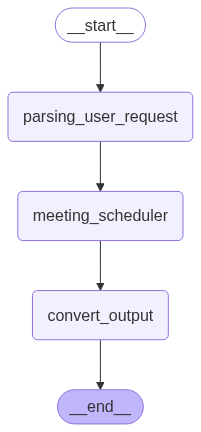

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response = graph.invoke({
    "user_request": request_thursday
})

HERE
LLM REsponse {'chain_of_thought': "Current date: 19-07-2025 (Saturday). 'Tomorrow' = current date + 1 day = 20-07-2025 (Sunday). No specific time mentioned, so applying defaults: start = 00:00:00. Duration explicitly stated as half an hour = 30 minutes. End time calculated as start + duration = 00:30:00.", 'start_date': '20-07-2025T00:00:00', 'end_date': '20-07-2025T00:30:00', 'duration_minutes': 30, 'priority': 3, 'summary': 'Sync Up Meeting'}
No of exceptions are:  1
No of exceptions are:  1
No of exceptions are:  2
{'user_request': {'Request_id': 'a2', 'Datetime': '19-07-2025T12:34:55', 'From': 'userone.amd@gmail.com', 'Attendees': [{'email': 'usertwo.amd@gmail.com'}, {'email': 'userthree.amd@gmail.com'}], 'EmailContent': "Let's sync up on tommorow for half an hour."}, 'meeting_request_input': {'Request_id': 'a2', 'Datetime': '19-07-2025T12:34:55', 'From': 'userone.amd@gmail.com', 'Attendees': [{'email': 'usertwo.amd@gmail.com'}, {'email': 'userthree.amd@gmail.com'}], 'EmailCon

In [27]:
print(json.dumps(response['final_output'],indent=2))

{
  "Request_id": "a2",
  "Datetime": "19-07-2025T12:34:55",
  "From": "userone.amd@gmail.com",
  "Attendees": [
    {
      "email": "userone.amd@gmail.com",
      "events": [
        {
          "StartTime": "2025-07-19T18:00:00+05:30",
          "EndTime": "2025-07-20T09:00:00+05:30",
          "NumAttendees": 1,
          "Attendees": [
            "SELF"
          ],
          "Summary": "Off Hours"
        },
        {
          "StartTime": "2025-07-20T07:45:00+05:30",
          "EndTime": "2025-07-20T08:15:00+05:30",
          "NumAttendees": 4,
          "Attendees": [
            "team@amd.com",
            "userthree.amd@gmail.com",
            "userone.amd@gmail.com",
            "usertwo.amd@gmail.com"
          ],
          "Summary": "Agentic AI Project Status Update"
        },
        {
          "StartTime": "2025-07-20T08:30:00+05:30",
          "EndTime": "2025-07-20T09:00:00+05:30",
          "NumAttendees": 4,
          "Attendees": [
            "team@amd.com",
 